In [1]:
import re
from pathlib import Path
from pprint import pp

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from P04_run_post_weld.T00_lib.classes import MyUtil
from P04_run_post_weld.T00_lib.utils import check_jupyter


In [2]:
SAVE_DATA = False
MAKE_ONE_HOT = True

In [3]:
if check_jupyter():
    BASE_DIR = Path.cwd()  # Current directory of the running file
    DATA_DIR = BASE_DIR.parent / "T02_combine_features"
    CURRENT_DIR = BASE_DIR
else:
    BASE_DIR = Path.cwd()  # Base directory of the project
    DATA_DIR = BASE_DIR / "src/P04_run_post_weld/T02_combine_features"
    CURRENT_DIR = Path(__file__).resolve().parent

dt = MyUtil.get_dt()
print(f"Current Directory: {CURRENT_DIR}")
print(f"Current Date and Time: {dt}")

# Load data
df = pd.read_excel(DATA_DIR / "S01_data_combined.xlsx")
print(df.shape)
df

Code is running in a Jupyter environment.
Current Directory: c:\Users\admin\Coding\research\weld-ml\src\P04_run_post_weld\T03_ml_trial
Current Date and Time: 2026-01-11_20-46
(54, 213)


,sample_no,R,W,D,AA5052_L1,AA5052_L2,AA5052_L3,AA5052_L4,AA5052_L5,AA5052_L6,...,weld_Fz__ar_coefficient__coeff_5__k_10,"weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","weld_Fz__fft_coefficient__attr_""real""__coeff_9","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2","weld_Fz__fft_coefficient__attr_""angle""__coeff_26","weld_Fz__fft_coefficient__attr_""angle""__coeff_86","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2",weld_Fz__ratio_beyond_r_sigma__r_2.5,weld_Fz__binned_entropy__max_bins_10,weld_Fz__kurtosis
0,1,1400,60,10,13,8,34,39,15,10,...,-0.687590,0.001825,58.401601,0.005640,-59.307464,-126.394608,0.000592,0.011999,1.996898,0.031761
1,2,1400,60,15,16,15,23,24,21,3,...,-0.702443,0.002662,188.462577,0.008885,-67.104324,-83.441169,0.001515,0.026536,1.433742,2.139541
2,3,1400,60,20,19,23,26,27,20,12,...,-0.627446,0.002434,79.638692,0.007856,-73.946166,-100.226178,0.002915,0.046766,1.651073,1.957977
3,4,1400,70,10,20,27,30,20,21,19,...,-1.099311,-0.001110,-8.572183,-0.001150,-109.557287,-92.120362,-0.002131,0.032843,1.331185,3.615244
4,5,1400,70,15,6,11,15,9,10,16,...,-0.927360,0.002638,34.610547,0.012461,142.508379,101.664911,0.005496,0.017408,1.739714,-0.003368
5,6,1400,70,20,14,8,-31,7,8,-16,...,-0.806930,0.001832,33.203157,0.013213,-123.751781,128.992926,0.004968,0.016870,1.817090,-0.038017
6,7,1400,80,10,18,21,19,14,8,2,...,-1.132776,0.000034,-1.471582,-0.001483,109.384614,-175.443311,-0.001755,0.025228,1.565542,0.625261
7,8,1400,80,15,12,15,14,16,4,10,...,-1.131650,0.002706,4.822293,0.014339,26.340215,108.289591,0.004093,0.019793,1.799426,0.132107
8,9,1400,80,20,19,34,29,27,29,13,...,-1.122219,-0.001139,45.767693,-0.003181,-16.370998,-158.923540,-0.001907,0.017024,1.664232,-0.107983
9,10,1500,60,10,10,18,13,11,4,5,...,-0.250355,-0.000594,51.619965,-0.007253,-64.816764,-90.705287,-0.001537,0.018691,1.753247,0.097989


In [4]:
stress_patterns = [r"AA5052", r"AA6061", r"Center"]
combined_pattern = "|".join(stress_patterns)
colsY = [c for c in df.columns if re.search(combined_pattern, c)]
colsX = [c for c in df.columns if c not in colsY]
print(colsY)
print(colsX)

['AA5052_L1', 'AA5052_L2', 'AA5052_L3', 'AA5052_L4', 'AA5052_L5', 'AA5052_L6', 'AA5052_L7', 'AA6061_L1', 'AA6061_L2', 'AA6061_L3', 'AA6061_L4', 'AA6061_L5', 'AA6061_L6', 'AA6061_L7', 'Center_L1', 'Center_L2', 'Center_L3', 'Center_L4', 'Center_L5', 'Center_L6', 'Center_L7', 'AA5052_mean', 'AA6061_mean', 'Center_mean']
['sample_no', 'R', 'W', 'D', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_48', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_73', 'dwell_Fz__ar_coefficient__coeff_10__k_10', 'dwell_Fz__ar_coefficient__coeff_6__k_10', 'dwell_Fz__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)', 'dwell_Fz__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)', 'dwell_Fz__quantile__q_0.2', 'dwell_Fz__quantile__q_0.3', 'dwell_Fz__quantile__q_0.1', 'dwell_Fz__energy_ratio_by_chunks__num_segments_10__segment_focus_0', 'dwell_Fz__index_mass_quantile__q_0.2', 'dwell_Fz__symmetry_looking__r_0.05', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_52', 'dwell_Fz__fft_coefficient__attr_"a

In [5]:
dfY = df[colsY]
dfX_all = df[colsX]

In [6]:
if MAKE_ONE_HOT:
    dft1 = pd.get_dummies(dfX_all, columns=["R", "W", "D"], drop_first=False, dtype=int)
    dfX = dft1.drop(columns=["sample_no"])
else:
    dfX = dfX_all.drop(columns=["sample_no"])
dfX

,"dwell_Fz__fft_coefficient__attr_""angle""__coeff_48","dwell_Fz__fft_coefficient__attr_""angle""__coeff_73",dwell_Fz__ar_coefficient__coeff_10__k_10,dwell_Fz__ar_coefficient__coeff_6__k_10,"dwell_Fz__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)","dwell_Fz__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)",dwell_Fz__quantile__q_0.2,dwell_Fz__quantile__q_0.3,dwell_Fz__quantile__q_0.1,dwell_Fz__energy_ratio_by_chunks__num_segments_10__segment_focus_0,...,weld_Fz__kurtosis,R_1400,R_1500,R_1600,W_60,W_70,W_80,D_10,D_15,D_20
0,-73.140582,-65.266073,-0.077099,0.052888,0.430529,0.699941,2.194000,2.222030,2.165700,0.125613,...,0.031761,1,0,0,1,0,0,1,0,0
1,-50.581536,-23.709687,-0.187110,0.061127,0.481377,0.745993,2.523190,2.552230,2.494990,0.111696,...,2.139541,1,0,0,1,0,0,0,1,0
2,-79.088993,-76.576054,0.025700,-0.056659,0.503995,0.782887,2.486750,2.511160,2.460940,0.113507,...,1.957977,1,0,0,1,0,0,0,0,1
3,-73.128327,-49.909967,-0.051432,-0.020606,0.546716,0.846394,2.802210,2.832860,2.780020,0.113762,...,3.615244,1,0,0,0,1,0,1,0,0
4,-76.940961,-132.636340,-0.226879,0.099458,0.436609,0.630152,0.893424,0.922372,0.864171,0.244256,...,-0.003368,1,0,0,0,1,0,0,1,0
5,-77.454453,-79.392907,-0.186431,0.194069,0.420062,0.657853,1.345040,1.465980,1.227370,0.165365,...,-0.038017,1,0,0,0,1,0,0,0,1
6,-72.909666,-79.580057,-0.291399,0.395539,0.478123,0.757512,1.898320,1.954000,1.671190,0.194886,...,0.625261,1,0,0,0,0,1,1,0,0
7,-76.135603,-81.774208,-0.113499,-0.033618,0.362032,0.564405,1.404420,1.428400,1.369890,0.150710,...,0.132107,1,0,0,0,0,1,0,1,0
8,-86.550161,-81.525618,-0.145309,0.085660,0.591456,0.919957,1.946320,1.997680,1.886340,0.149425,...,-0.107983,1,0,0,0,0,1,0,0,1
9,-75.575005,-80.441577,-0.023123,0.041016,0.510090,0.814512,2.205070,2.244960,2.163870,0.140982,...,0.097989,0,1,0,1,0,0,1,0,0


In [7]:
# Extract features and targets
_X = dfX.values
_Y = dfY.values

print(_X.shape)
print(_Y.shape)

(54, 194)
(54, 24)


In [8]:
_X_train, _X_test, _Y_train, _Y_test = train_test_split(
    _X, _Y, test_size=0.2, random_state=1
)
print(_X_train.shape)
print(_X_test.shape)
print(_Y_train.shape)
print(_Y_test.shape)

(43, 194)
(11, 194)
(43, 24)
(11, 24)


In [9]:
scX = StandardScaler()
X_train = scX.fit_transform(_X_train)
X_test = scX.transform(_X_test)

scY = StandardScaler()
Y_train = scY.fit_transform(_Y_train)
Y_test = scY.transform(_Y_test)

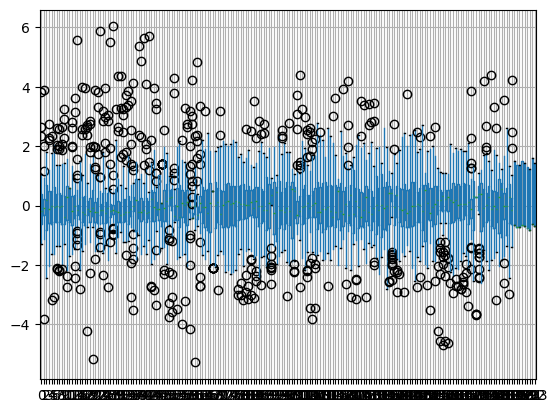

In [10]:
# _X_train.boxplot(figsize=(20,5))
pd.DataFrame(X_train).boxplot()
plt.show()

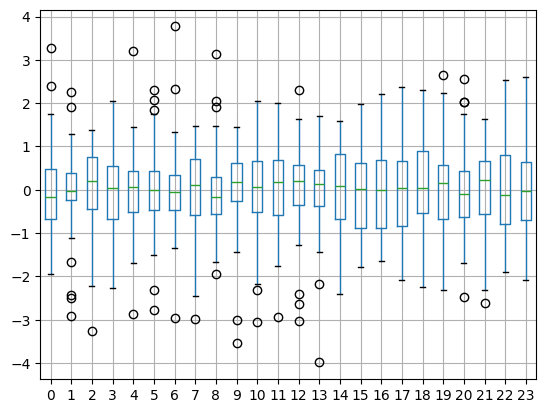

In [11]:
pd.DataFrame(Y_train).boxplot()
plt.show()

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver="full")
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(43, 3)
(11, 3)


In [13]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# reg = MultiOutputRegressor(estimator=SVR(C=100))
# reg = MultiOutputRegressor(estimator=LinearRegression())
# reg = MultiOutputRegressor(
#     estimator=RandomForestRegressor(n_estimators=200, random_state=0)
# )
# reg = MultiOutputRegressor(
#     estimator=GradientBoostingRegressor(n_estimators=200, random_state=0, max_depth=1)
# )
reg = MultiOutputRegressor(
    estimator=XGBRegressor(n_estimators=200, random_state=0, max_depth=1)
)

In [14]:
reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=1,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [15]:
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

print(Y_train_pred.shape)
print(Y_test_pred.shape)

(43, 24)
(11, 24)


In [16]:
def eval_perf(y_true, y_pred):
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    return mse, mape, r2


def print_perf(data):
    for k, v in data.items():
        print(k, ":", v)


data_arr = []
for i in range(0, _Y.shape[1]):
    mse_train, mape_train, r2_train = eval_perf(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    mse_test, mape_test, r2_test = eval_perf(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )

    data = {
        "Y": f"Y-{i + 1}",
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "MAPE Train": mape_train,
        "MAPE Test": mape_test,
        "R2 Train": r2_train,
        "R2 Test": r2_test,
    }
    # print_perf(data)

    data_arr.append(data)

mse_train, mape_train, r2_train = eval_perf(y_true=Y_train, y_pred=Y_train_pred)
mse_test, mape_test, r2_test = eval_perf(y_true=Y_test, y_pred=Y_test_pred)
print_perf(data)

data = {
    "Y": "Y-All",
    "MSE Train": mse_train,
    "MSE Test": mse_test,
    "MAPE Train": mape_train,
    "MAPE Test": mape_test,
    "R2 Train": r2_train,
    "R2 Test": r2_test,
}
data_arr.append(data)
# print_perf(data)

df_eval = pd.DataFrame.from_dict(data_arr)
display(df_eval)

if SAVE_DATA:
    filename = f"eval_{dt}.xlsx"
    df_eval.to_excel(filename, index=False)

Y : Y-24
MSE Train : 0.11275294510919107
MSE Test : 1.8859850873065598
MAPE Train : 0.9637417816302469
MAPE Test : 1.4251729046987534
R2 Train : 0.8872470548908089
R2 Test : -0.7137762148827462


,Y,MSE Train,MSE Test,MAPE Train,MAPE Test,R2 Train,R2 Test
0,Y-1,0.220058,3.918696,1.098514,8.298066,0.779942,-0.484512
1,Y-2,0.086453,1.248591,2.165699,5.957052,0.913547,-3.961402
2,Y-3,0.170886,0.895882,3.327290,1.478451,0.829114,-0.554197
3,Y-4,0.216765,0.953538,0.819305,4.734034,0.783235,-0.644392
4,Y-5,0.238660,0.480296,1.213047,6.236375,0.761340,-2.126111
5,Y-6,0.172028,1.268575,0.520544,27.195273,0.827972,-1.470410
6,Y-7,0.229047,0.476049,0.828859,3.085875,0.770953,-2.760303
7,Y-8,0.178682,1.407551,2.056299,1.397619,0.821318,-0.879046
8,Y-9,0.224268,0.417237,0.875803,4.652969,0.775732,-0.716858
9,Y-10,0.096427,1.546869,1.326022,4.991868,0.903573,-0.655875


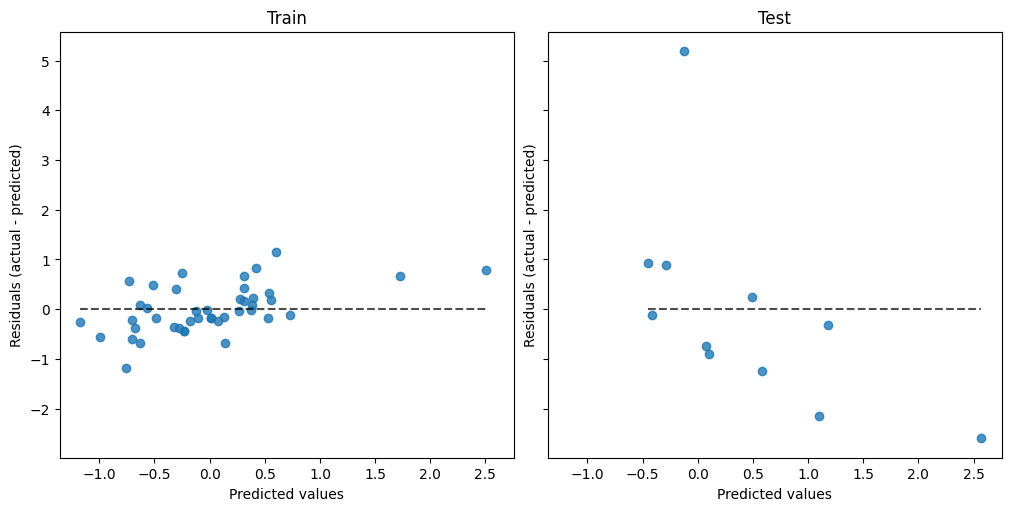

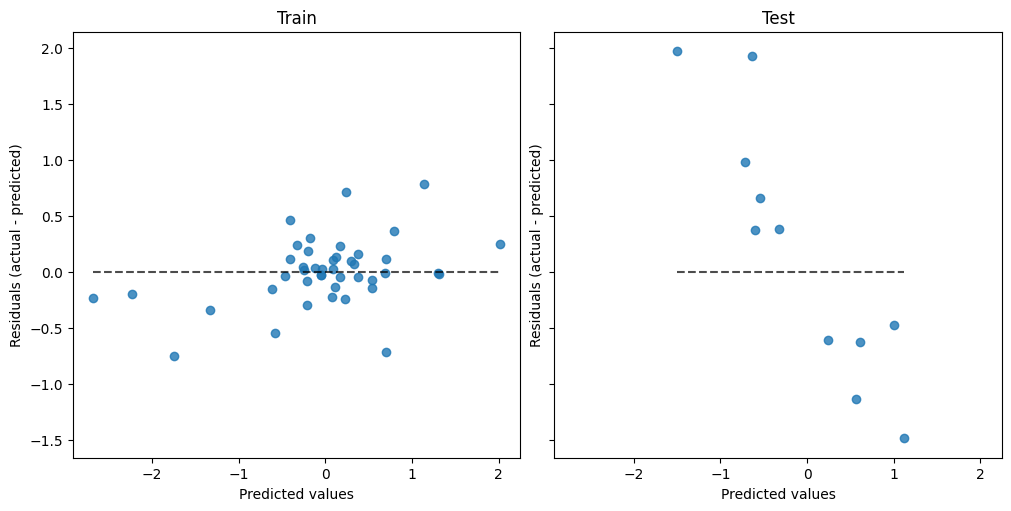

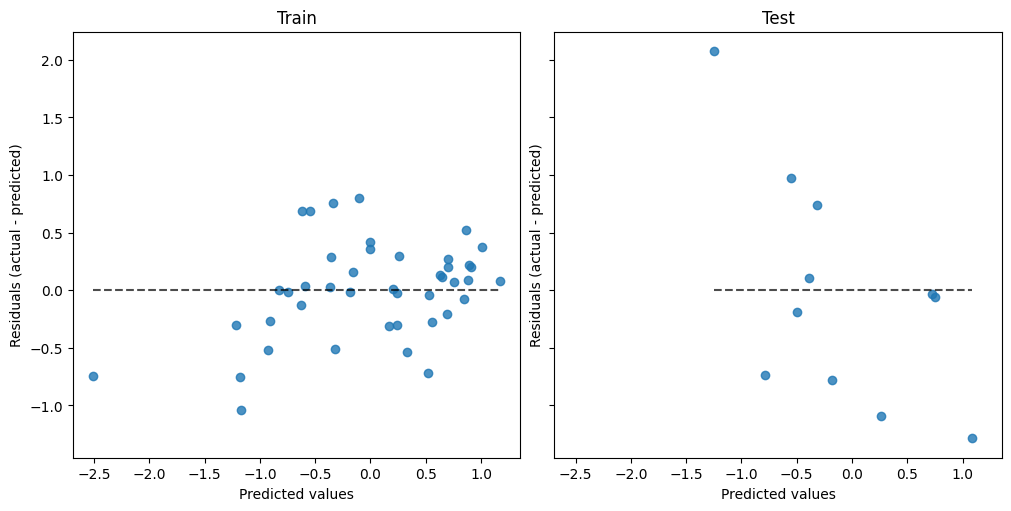

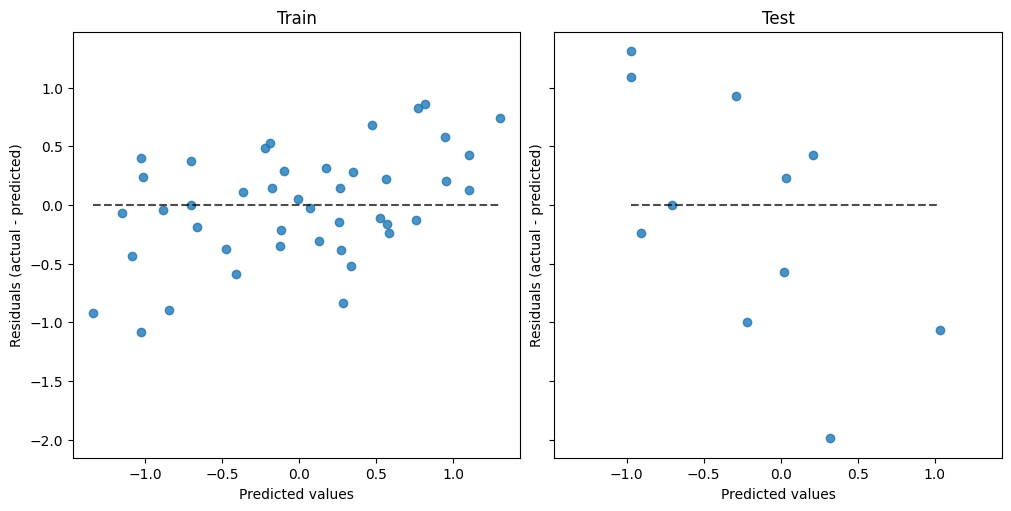

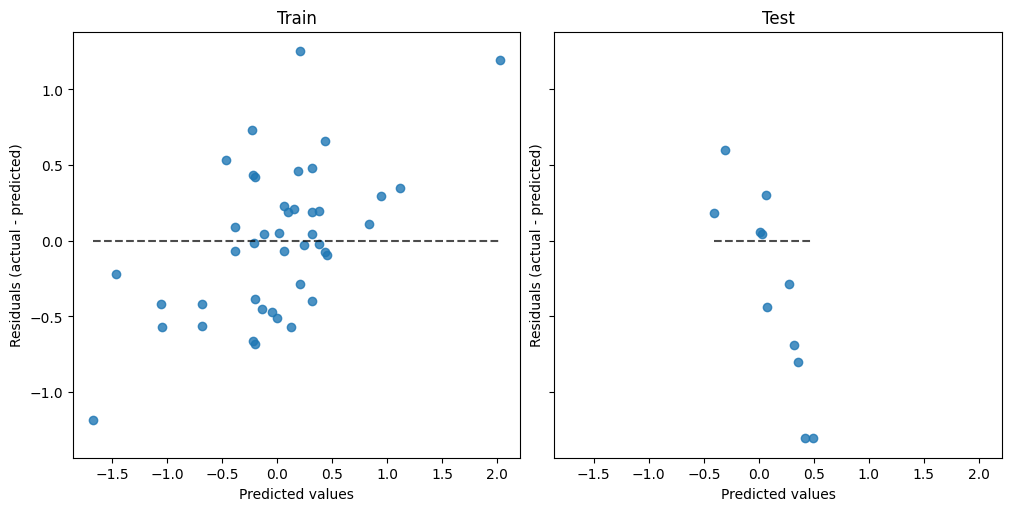

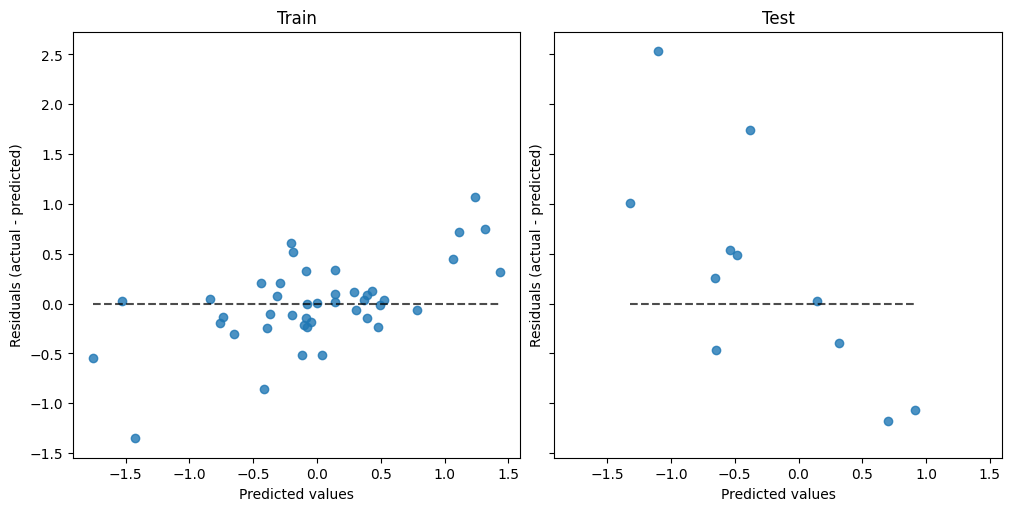

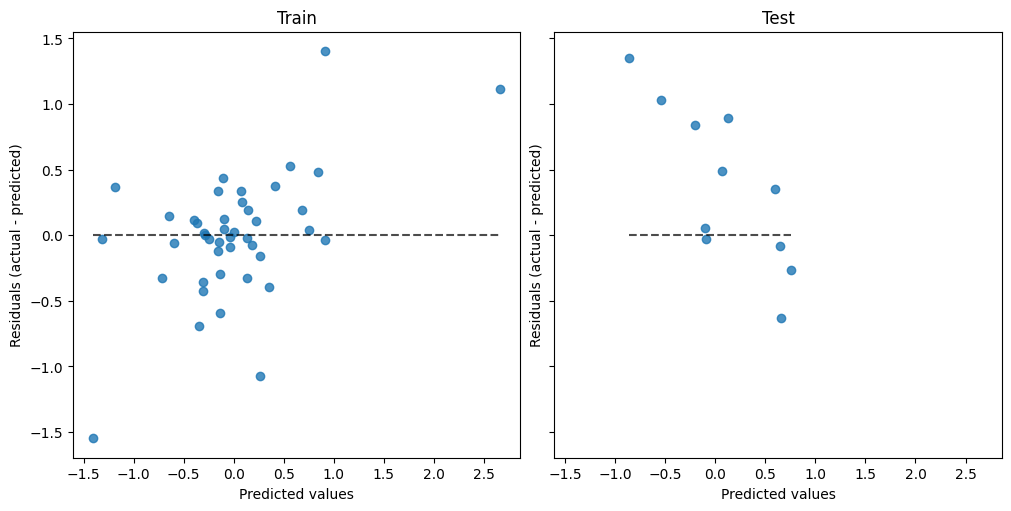

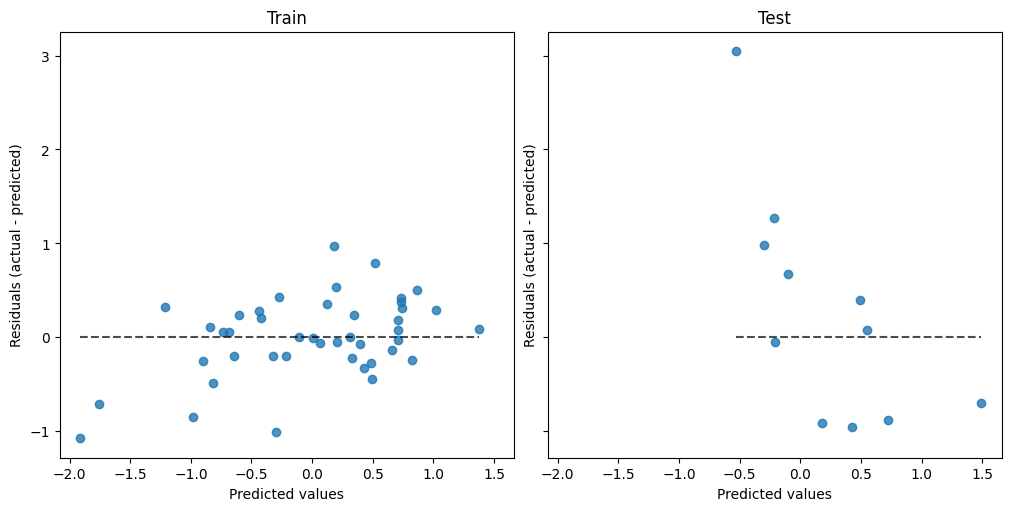

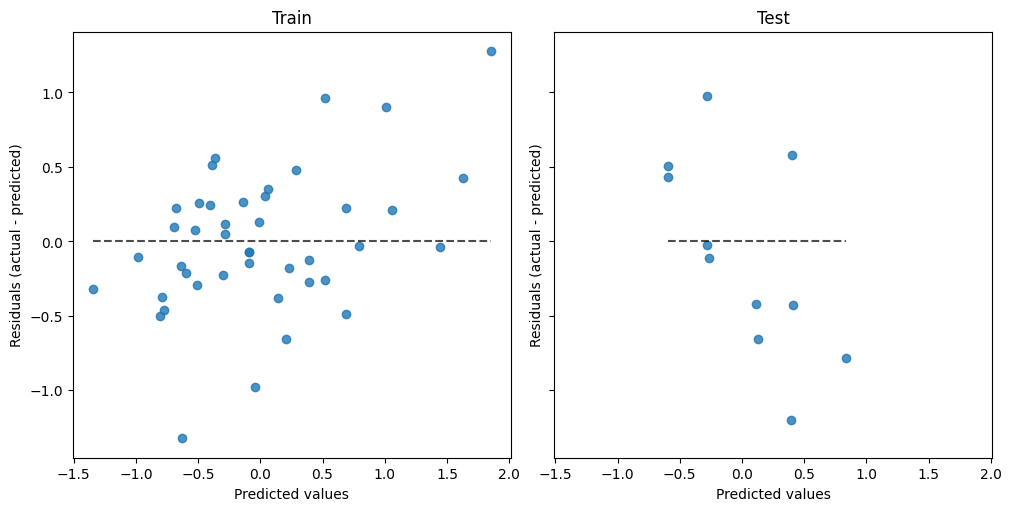

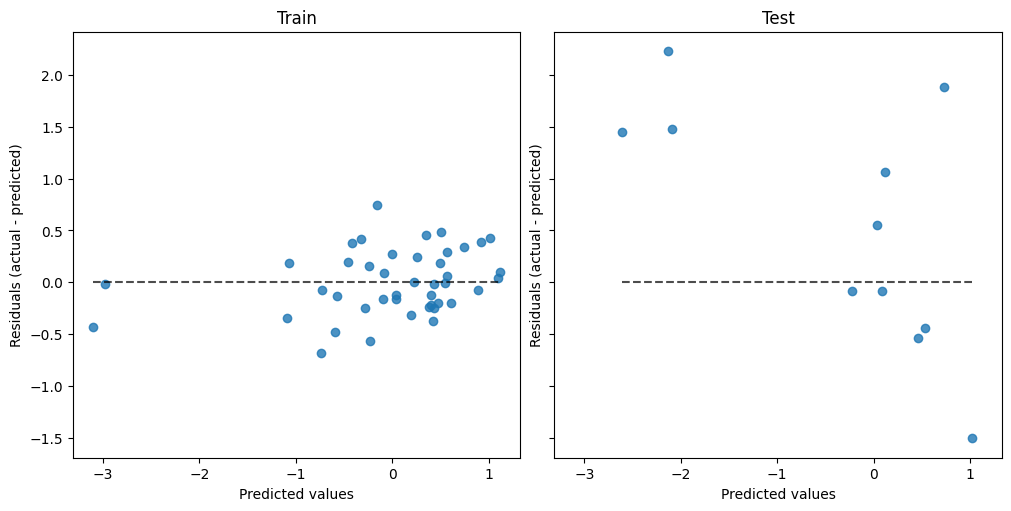

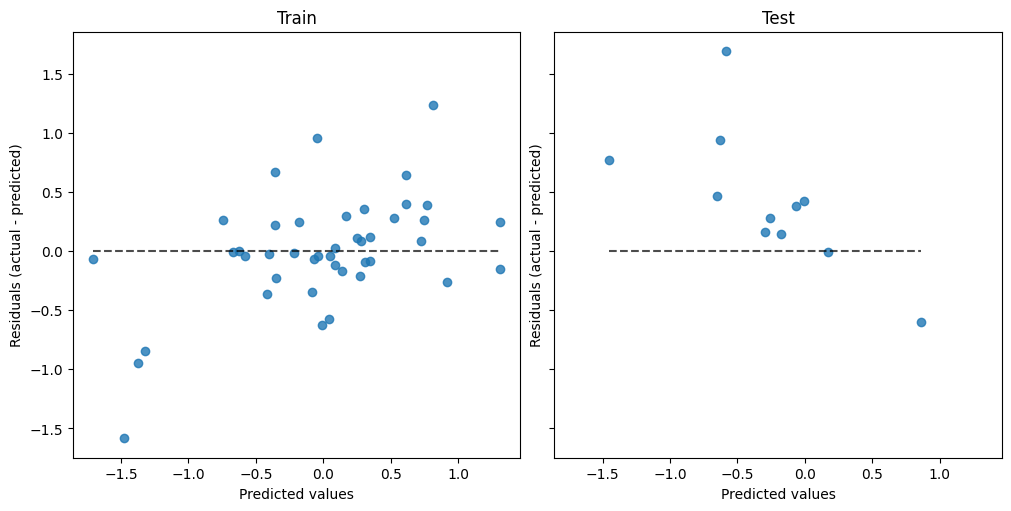

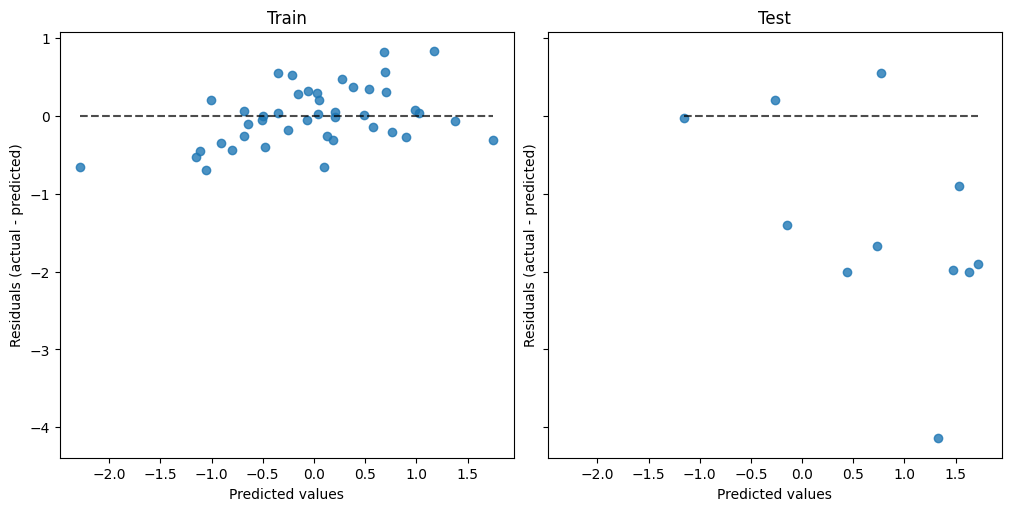

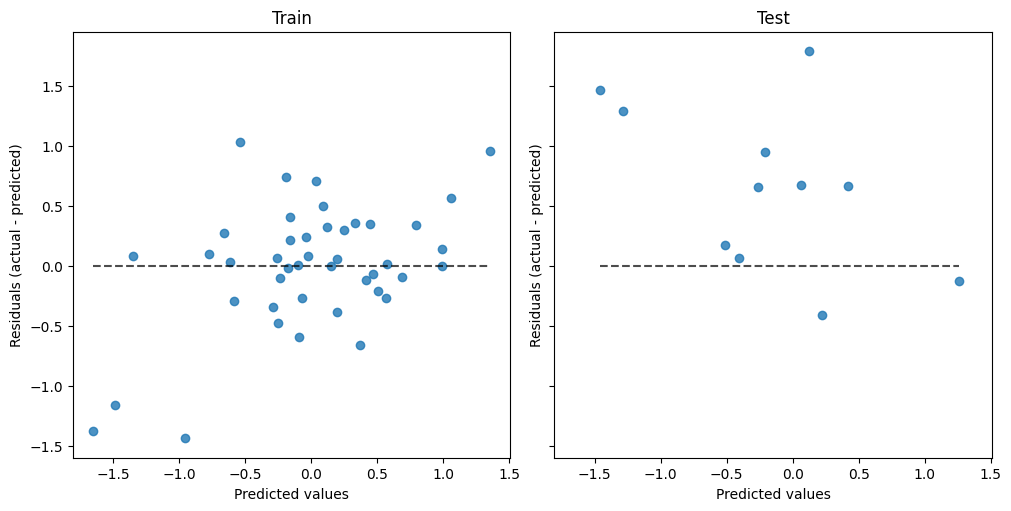

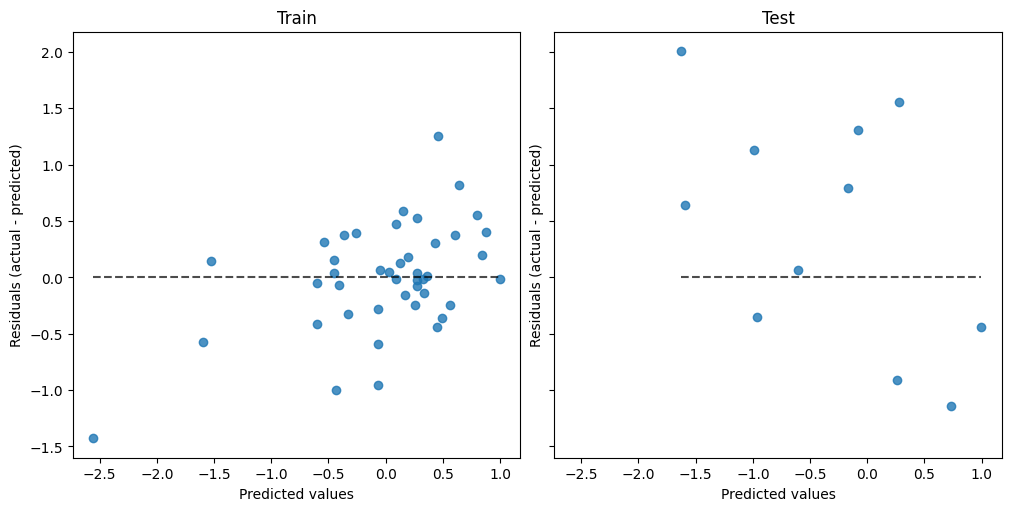

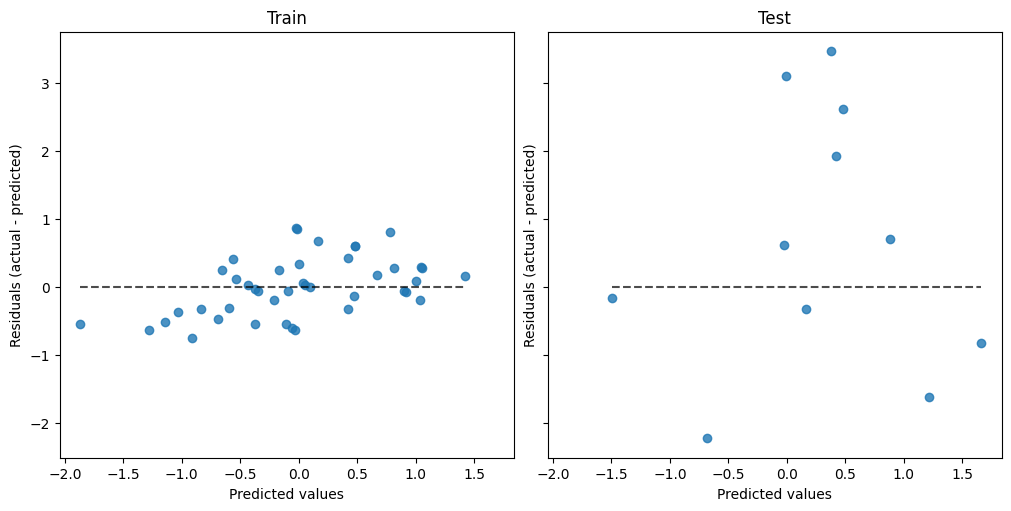

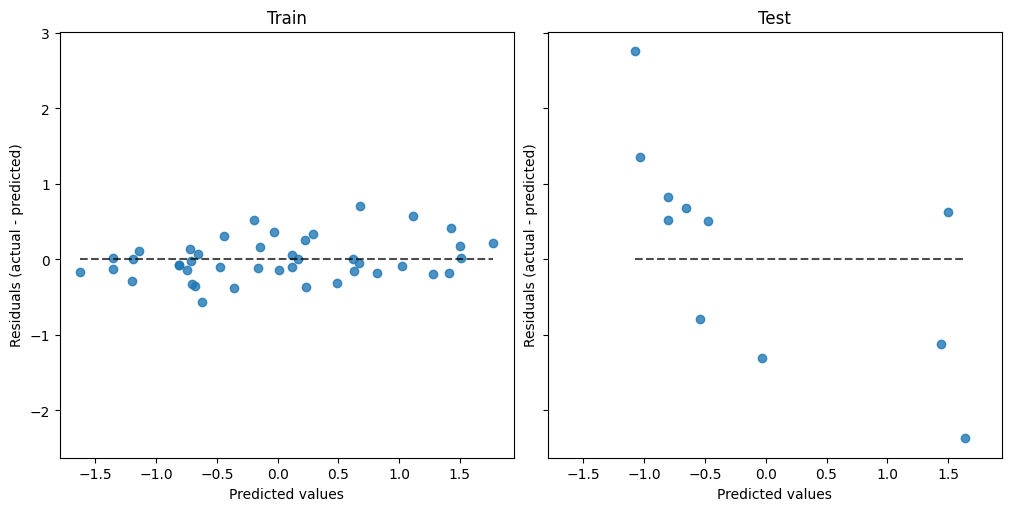

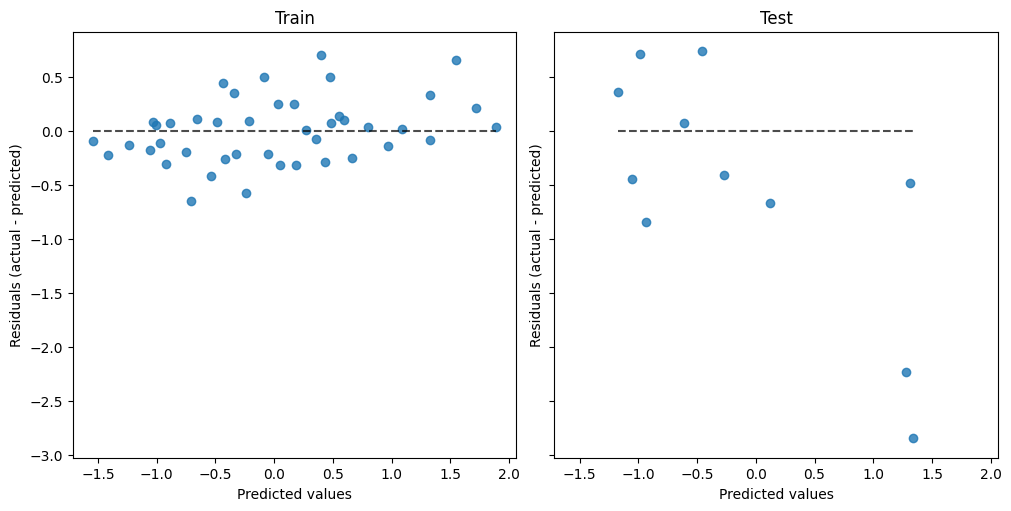

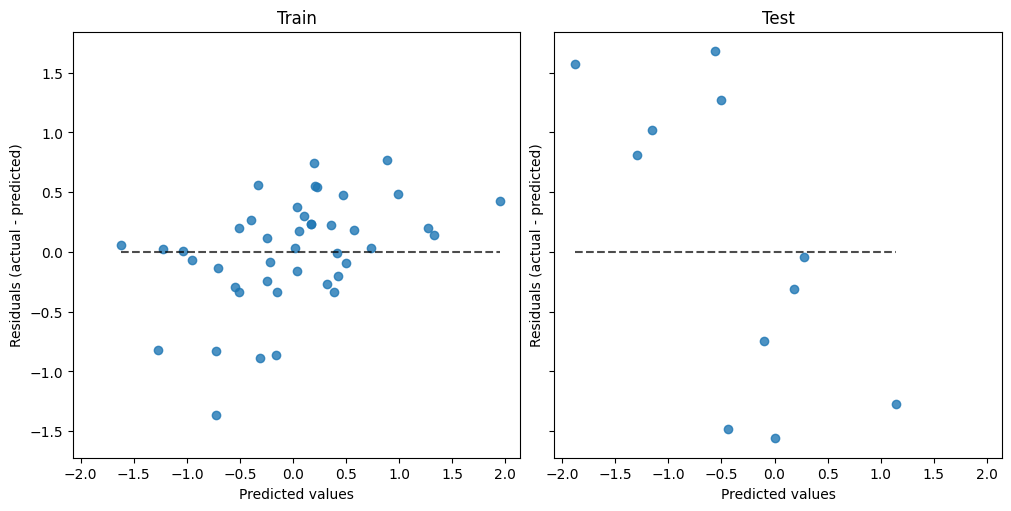

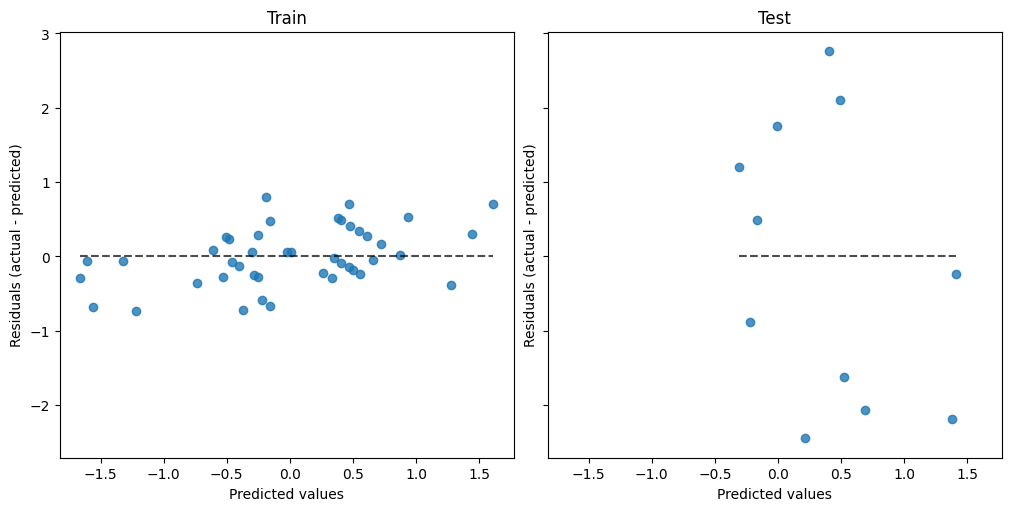

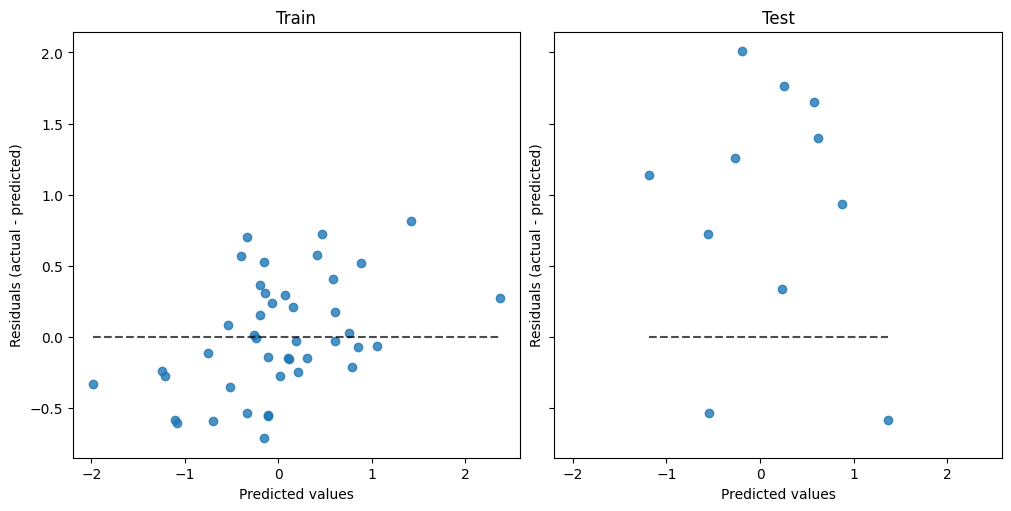

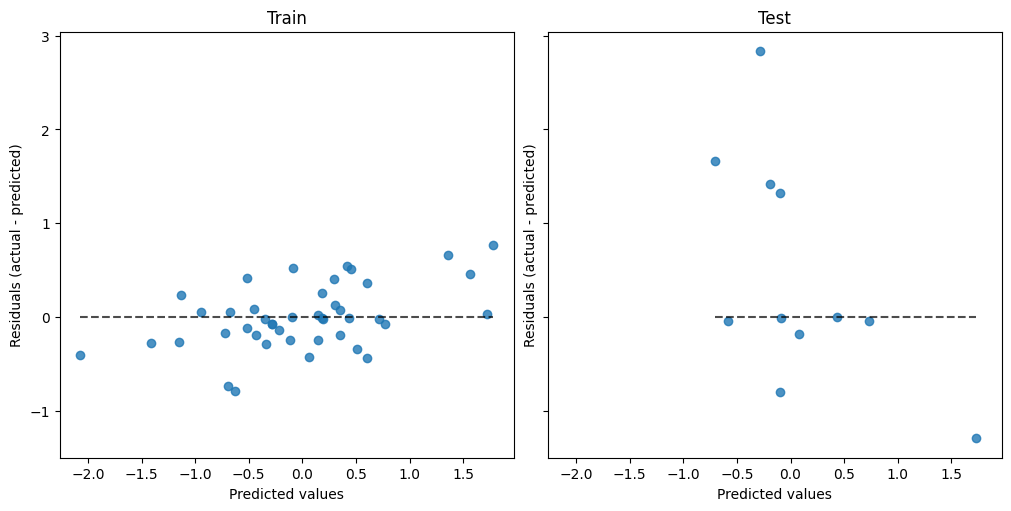

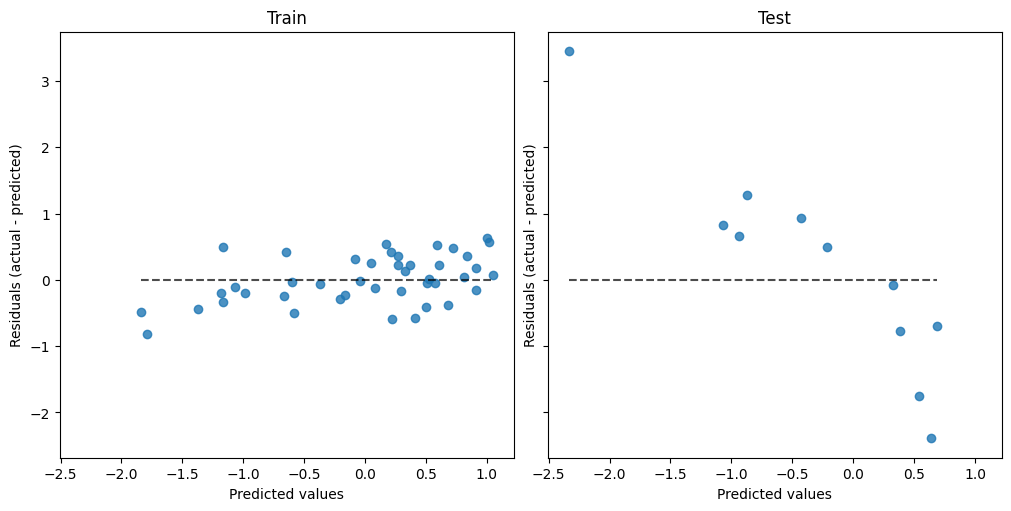

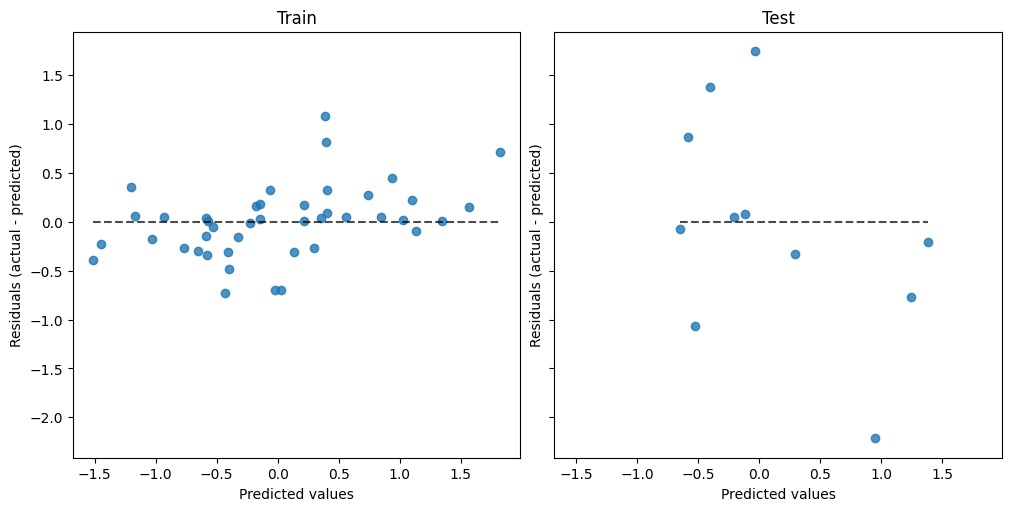

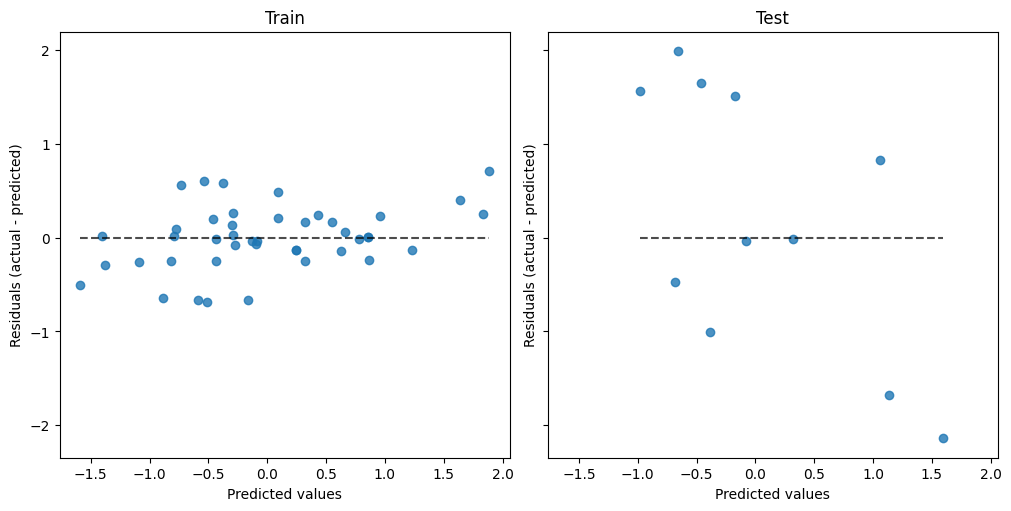

In [17]:
for i in range(0, _Y.shape[1]):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(10, 5),
        constrained_layout=True,
        sharex=True,
        sharey=True,
    )

    display_train = PredictionErrorDisplay(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    display_train.plot(ax=axes[0])
    axes[0].set_title("Train")

    display_train = PredictionErrorDisplay(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )
    display_train.plot(ax=axes[1])
    axes[1].set_title("Test")

    if SAVE_DATA:
        filename = f"res_plot_{dt}_{i}.png"
        fig.savefig(filename, dpi=300)

    plt.show()